In [ ]:
#Proyecto Capstone Análisis de datos 
#2022 – unico integrante: Ricardo Ovando
#■ tema a analizar: Precios de casas, dataset ames housing
#■ problema específico: predecir precios de las casas en ames iowa,usando 
#multiples variables, y descubrir a través del análisis cuales son las variables 
#principales para generar el modelo
#■ La variable que se quiere predecir: predecir los precios en el año 2023 (sale price).
#parte 3: reporte

**limpieza de datos: (archivo 1_limpieza)**

* se eliminan outliers muy evidentes de precios vs calidad que estaban muy por bajo lo que deberian costar
* se borra columna PID porque no necesitamos otro indice
* se revisa la data faltante (nulls) en las columnas y se arregla la data
se reemplaza por cero donde la caracteristica diga que ese dato es vacio porque no tiene esa caracteristica (piscina, sotano, etc)
* se modifican las variables categoricas por dummies para poder hacer analisis




**analisis y Seleccion de features: (archivo 2_analisis)**

* usando el dataset generado en el paso anterior hago una matriz de correlacion para ver que caracteristicas tienen una mayor correlacion en lo que se refiere al precio de venta, seleccionare las mejores para generar un modelo



In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
#lectura de archivo generado en el paso de limpieza
df= pd.read_csv('../data/processed/df_paso1.csv')
df.head()

,Unnamed: 0,Order,Lot.Frontage,Lot.Area,Overall.Qual,Overall.Cond,Year.Built,Year.Remod.Add,Mas.Vnr.Area,BsmtFin.SF.1,...,Sale.Type_ConLw,Sale.Type_New,Sale.Type_Oth,Sale.Type_VWD,Sale.Type_WD,Sale.Condition_AdjLand,Sale.Condition_Alloca,Sale.Condition_Family,Sale.Condition_Normal,Sale.Condition_Partial
0,0,1,141.0,31770,6,5,1960,1960,112.0,639.0,...,0,0,0,0,1,0,0,0,1,0
1,1,2,80.0,11622,5,6,1961,1961,0.0,468.0,...,0,0,0,0,1,0,0,0,1,0
2,2,3,81.0,14267,6,6,1958,1958,108.0,923.0,...,0,0,0,0,1,0,0,0,1,0
3,3,4,93.0,11160,7,5,1968,1968,0.0,1065.0,...,0,0,0,0,1,0,0,0,1,0
4,4,5,74.0,13830,5,5,1997,1998,0.0,791.0,...,0,0,0,0,1,0,0,0,1,0


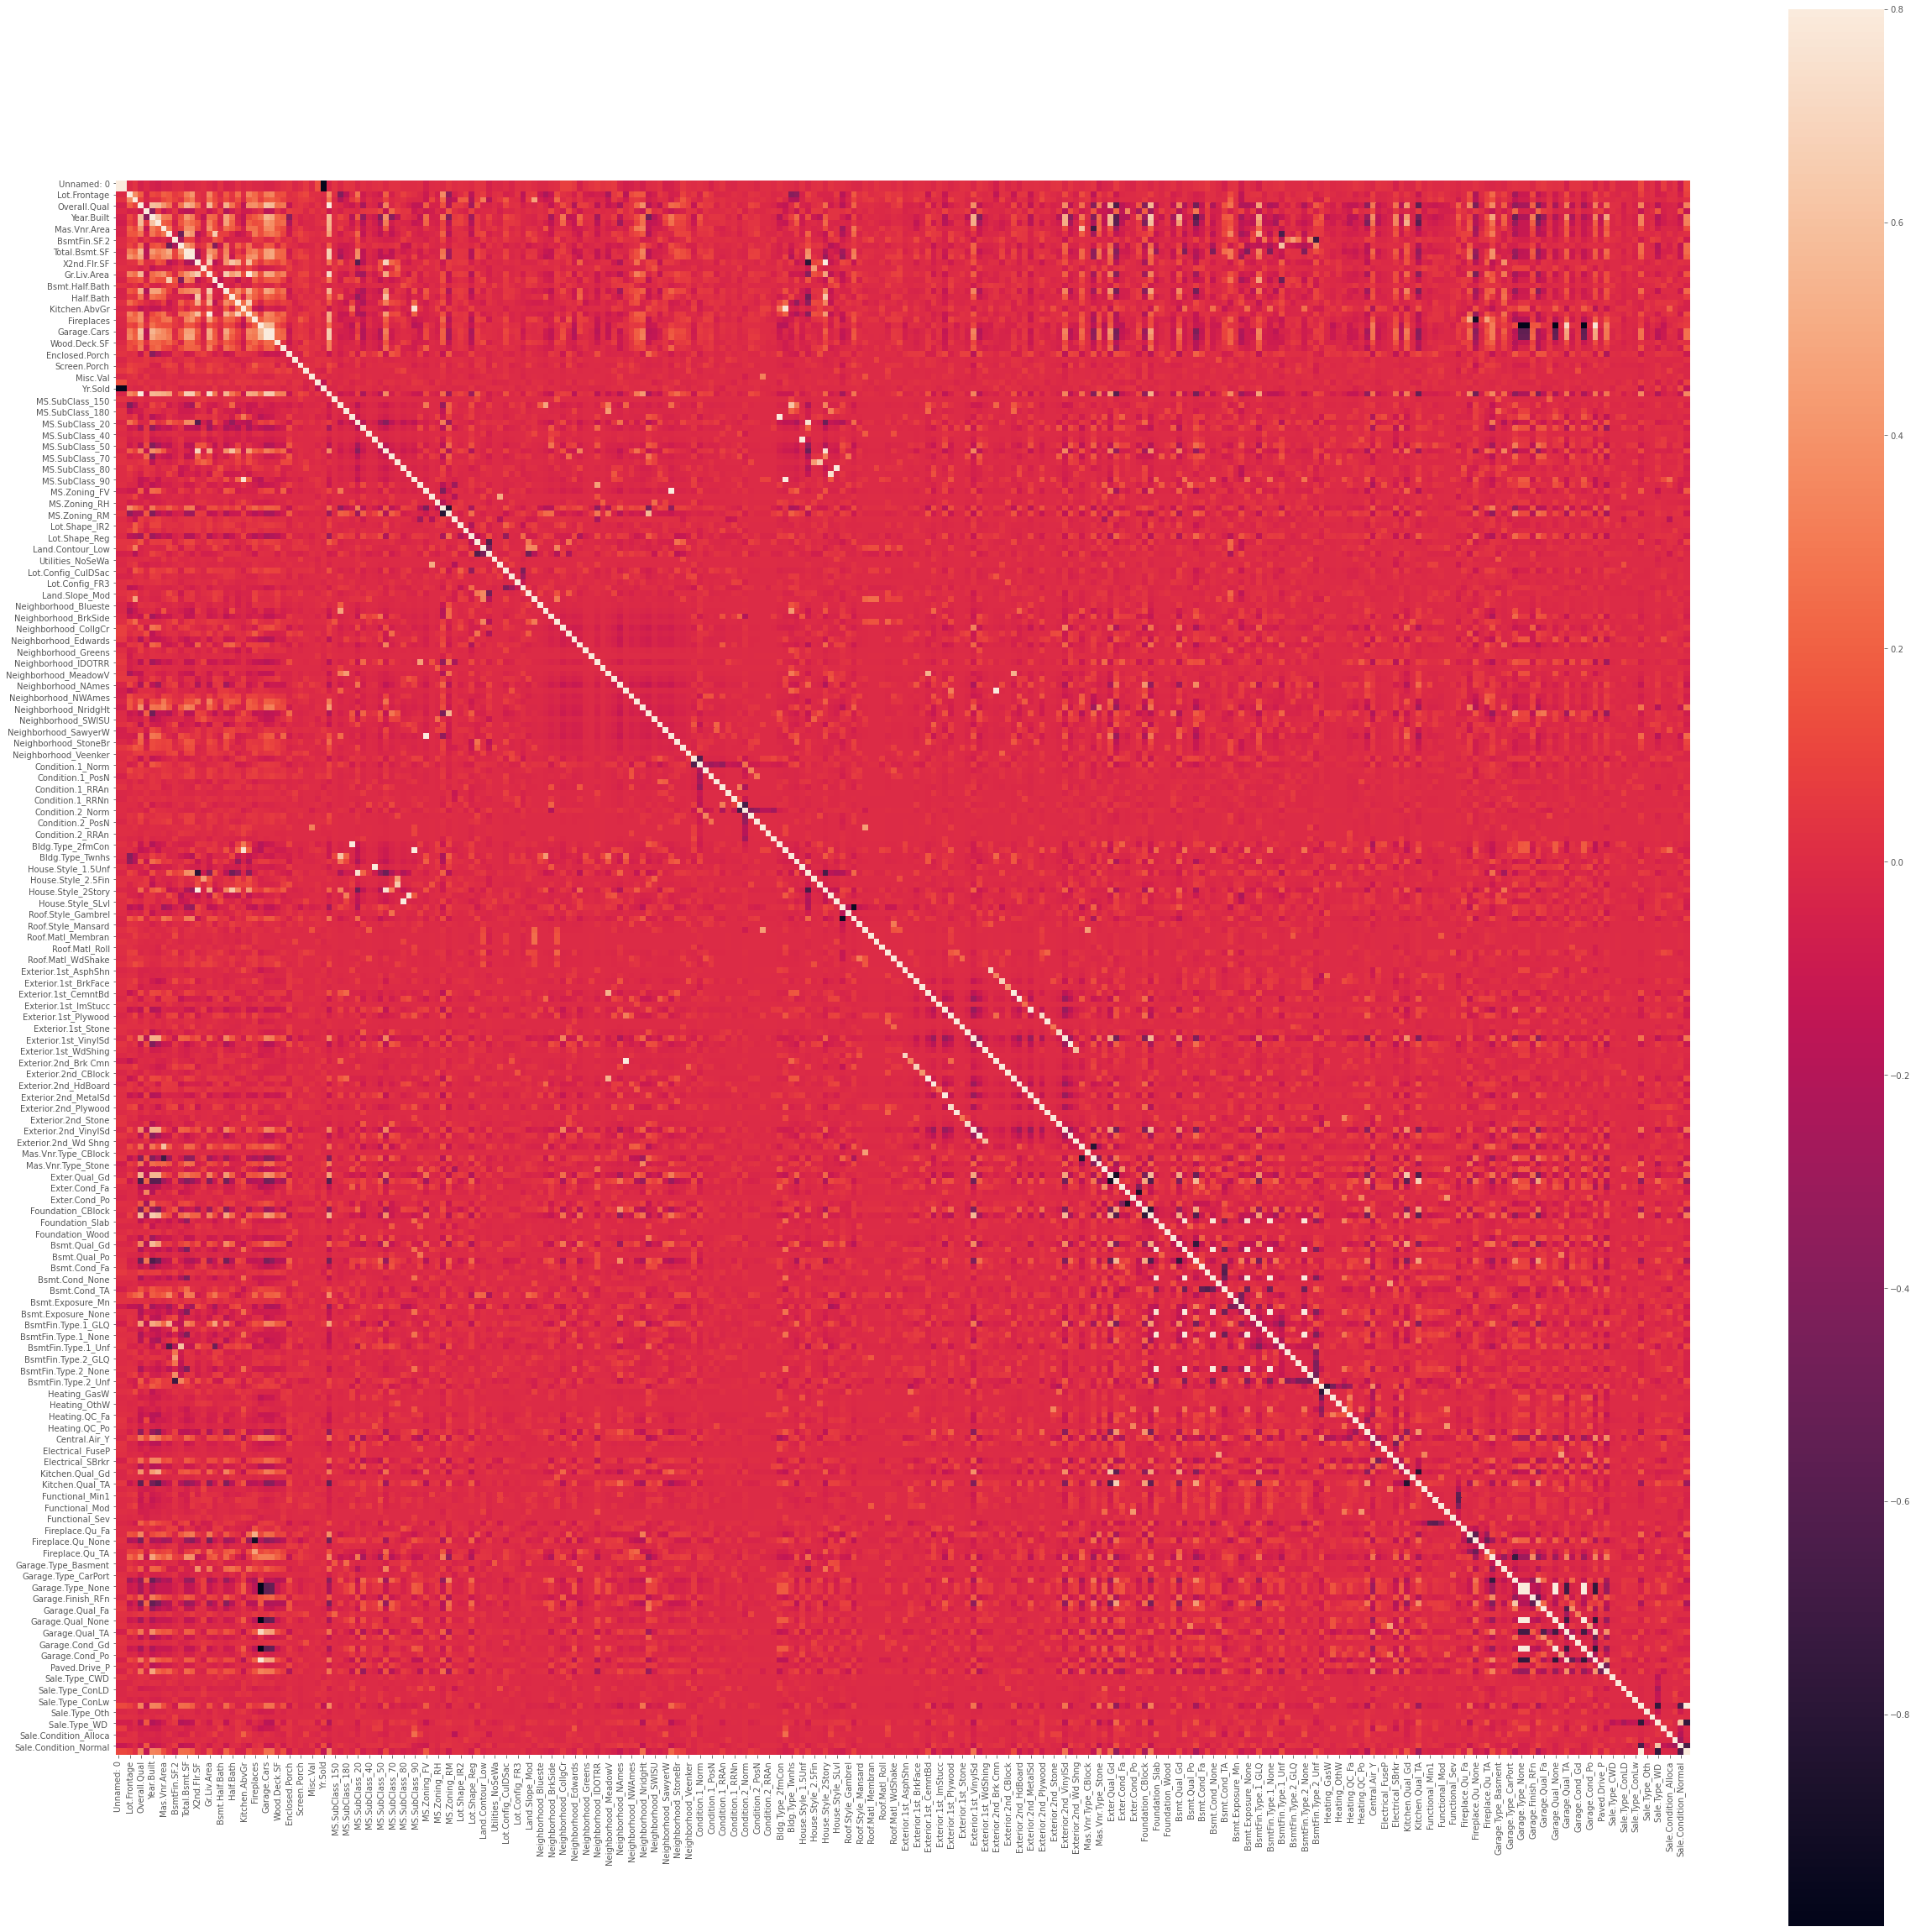

In [3]:
#creando una matriz de correlacion para seleccionar features relevantes
corrmat = df.corr()
f, ax = plt.subplots(figsize=(42, 42))
sns.heatmap(corrmat, vmax=.8, square=True);


In [4]:
#es demasiadas columnas como para que podamos observar algo util a partir de una matriz de correlacion
#asi que la trabajare directamente con la data
#ordenando las columnas por correlacion entre las variables y salesprice
df_correlaciones = pd.DataFrame([df.corr()['SalePrice'].sort_values()])

In [5]:
#mostrando las variables que pueden influir mas en el precio
df_correlaciones.iloc[:,-10:]

,Year.Remod.Add,Full.Bath,Year.Built,Garage.Area,X1st.Flr.SF,Garage.Cars,Total.Bsmt.SF,Gr.Liv.Area,Overall.Qual,SalePrice
SalePrice,0.533733,0.546645,0.559165,0.644368,0.645635,0.648488,0.660983,0.727279,0.802637,1.0


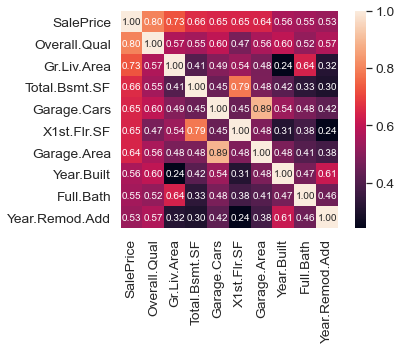

In [6]:
k = 10 #numero de variables
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

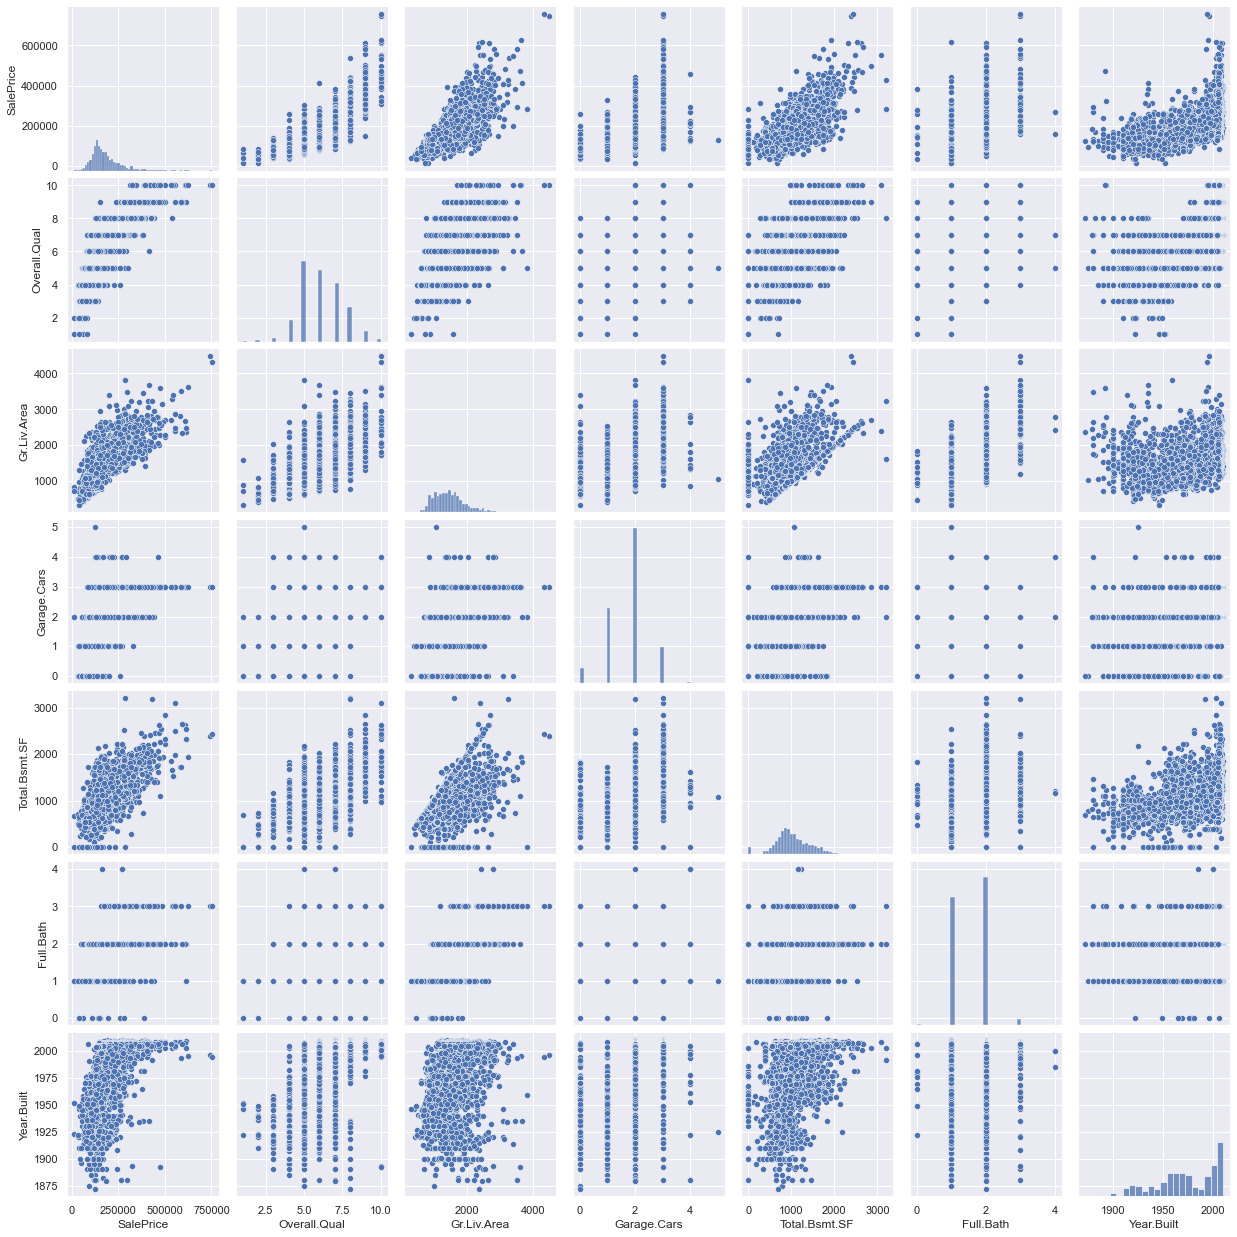

In [7]:
#viendo graficamente la distribucion de las variables
sns.set()
cols = ['SalePrice', 'Overall.Qual', 'Gr.Liv.Area', 'Garage.Cars', 'Total.Bsmt.SF', 'Full.Bath', 'Year.Built']
sns.pairplot(df[cols], size = 2.5)
plt.show();

In [8]:
#separando los datos para hacer la regresion
y = df['SalePrice']


X = df[cols]
X = X.drop(['SalePrice'], axis=1)
X.shape

(2925, 6)

In [9]:
X.head()

,Overall.Qual,Gr.Liv.Area,Garage.Cars,Total.Bsmt.SF,Full.Bath,Year.Built
0,6,1656,2.0,1080.0,1,1960
1,5,896,1.0,882.0,1,1961
2,6,1329,1.0,1329.0,1,1958
3,7,2110,2.0,2110.0,2,1968
4,5,1629,2.0,928.0,2,1997


In [10]:

#separando para regresion lineal
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=61)

In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [12]:
# fit de regresion lineal y estimacion de parametros
ols = LinearRegression()
ols.fit(X_train, y_train)

print("Intercept:", ols.intercept_)
print("Coefficients:", ols.coef_)

Intercept: 181320.22960429895
Coefficients: [27021.57241392 34452.75728317  7350.75077705 17566.36958906
 -7347.84621835 12633.52476741]


In [13]:
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn import metrics, linear_model

# MSE y RMSE
def scores(model, X, y):
    yhat = model.predict(X)
    print('MSE', np.round(metrics.mean_squared_error(y, yhat), 4)) 
    print('RMSE', np.round((metrics.mean_squared_error(y, yhat))**0.5, 4)) 

scores(ols, X_test, y_test)


MSE 987911474.6351
RMSE 31431.0591


Text(0.5, 1.0, 'Predicciones de precio venta vs precio real')

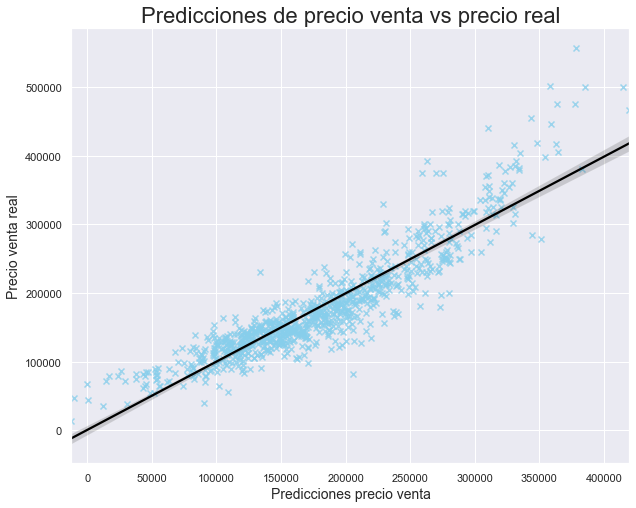

In [14]:
# crear scatterplot para mostrar predicciones vs valores reals
predicciones = ols.predict(X_test)

plt.figure(figsize=(10,8))
sns.regplot(data=X_train, x=predicciones, y=y_test, marker='x', color='skyblue', line_kws={'color':'black'})
plt.xlabel('Predicciones precio venta', fontsize=14)
plt.ylabel('Precio venta real', fontsize=14)
plt.title('Predicciones de precio venta vs precio real', fontsize=22)

In [16]:
X_train = sm.add_constant(X_train, prepend=True)
#prepend constante primera columna

X_train = np.array(X_train)
y_train = np.array(y_train)

modelo = sm.OLS(endog=y_train, exog=X_train,)

modelo = modelo.fit()
print(modelo.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     1545.
Date:                Wed, 19 Oct 2022   Prob (F-statistic):               0.00
Time:                        00:36:04   Log-Likelihood:                -24290.
No. Observations:                2047   AIC:                         4.859e+04
Df Residuals:                    2040   BIC:                         4.863e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.813e+05    762.559    237.779      0.0

**Analisis y Conclusiones:**

como podemos ver las predicciones hechas con la regresion realizada se ajusta bastante a los valores reales, tambien del r cuadrado podemos ver que explica la variabilidad del modelo a un 82% que es una cantidad significante de la varianza.
en los predictores podemos ver que son estadisticamente significativos porque sus p-values son 0.000, en cuanto a un analisis general de los caracteristicas del modelo, fueron significativas cosas como la calidad de la casa, el tamaño (Gr.Liv.Area,Garage.Cars,Full.Bath) pero este modelo esta limitado por otras caracteristicas que podrian no ser significativas en otros datasets de otras regiones ya que como habia mencionado en el ppt introductorio al trabajo la localidad de Ames en Iowa es un lugar que tiene riesgo por sobre el promedio de su estado en cuanto a sufrir tornados, lo que hace sentido al ver este par de variables que tienen una correlacion significativa: (Tamaño del sotano -Total.Bsmt.SF- (que la casa tenga lugares de refugio) ,  año de construccion -Year.Built- implica casas que resistieron muchos tornados antes), este par de caracteristicas pueda que no tenga mucha significancia estadistica en otros lugares.


fuentes:
riesgos de tornado en iowa
https://www.homefacts.com/tornadoes/Iowa/Story-County/Ames.html

